# MDA + RBF

In [1]:
import numpy as np
import pandas as pd
from bluemath_tk.datamining.mda import MDA
from bluemath_tk.datamining.lhs import LHS
from bluemath_tk.interpolation.rbf import RBF

from utils.plotting import plot_variable_combinations
import matplotlib.pyplot as plt
from matplotlib import gridspec

## Generate Dataset

### Generate set of data from LHS

In [2]:

dimensions_names = ['Hs', 'Tp', 'Dir']
lower_bounds = [0, 3, 0]
upper_bounds = [7, 20, 360]
num_samples = 5000

lhs = LHS(num_dimensions=len(dimensions_names), seed=0)
data = lhs.generate(
    dimensions_names=dimensions_names,
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds,
    num_samples=num_samples,
)
data

2025-03-31 18:57:45,680 - LHS - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.


,Hs,Tp,Dir
0,6.304708,16.881283,74.445050
1,1.559577,9.814235,87.918282
2,0.878351,7.284920,126.392859
3,0.457891,13.540626,153.575803
4,0.956400,9.949486,56.611465
...,...,...,...
4995,4.594856,7.112538,290.918683
4996,3.119144,15.155431,237.694065
4997,1.815617,19.624995,22.539618
4998,4.265459,11.671846,316.059564


In [3]:
num_centers = 100
dir_vars = ['Dir']

mda = MDA(num_centers=num_centers)
nearest_centroids_idxs, nearest_centroids_df = mda.fit_predict(
    data=data,
    directional_variables=dir_vars,
)

2025-03-31 18:57:45,698 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.


/lustre/geocean/WORK/users/Laura/BlueMath/toolkit/datamining/utils/plotting.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(v1, v2, c=data_color, s=size_point, cmap  = 'rainbow', alpha=0.2)


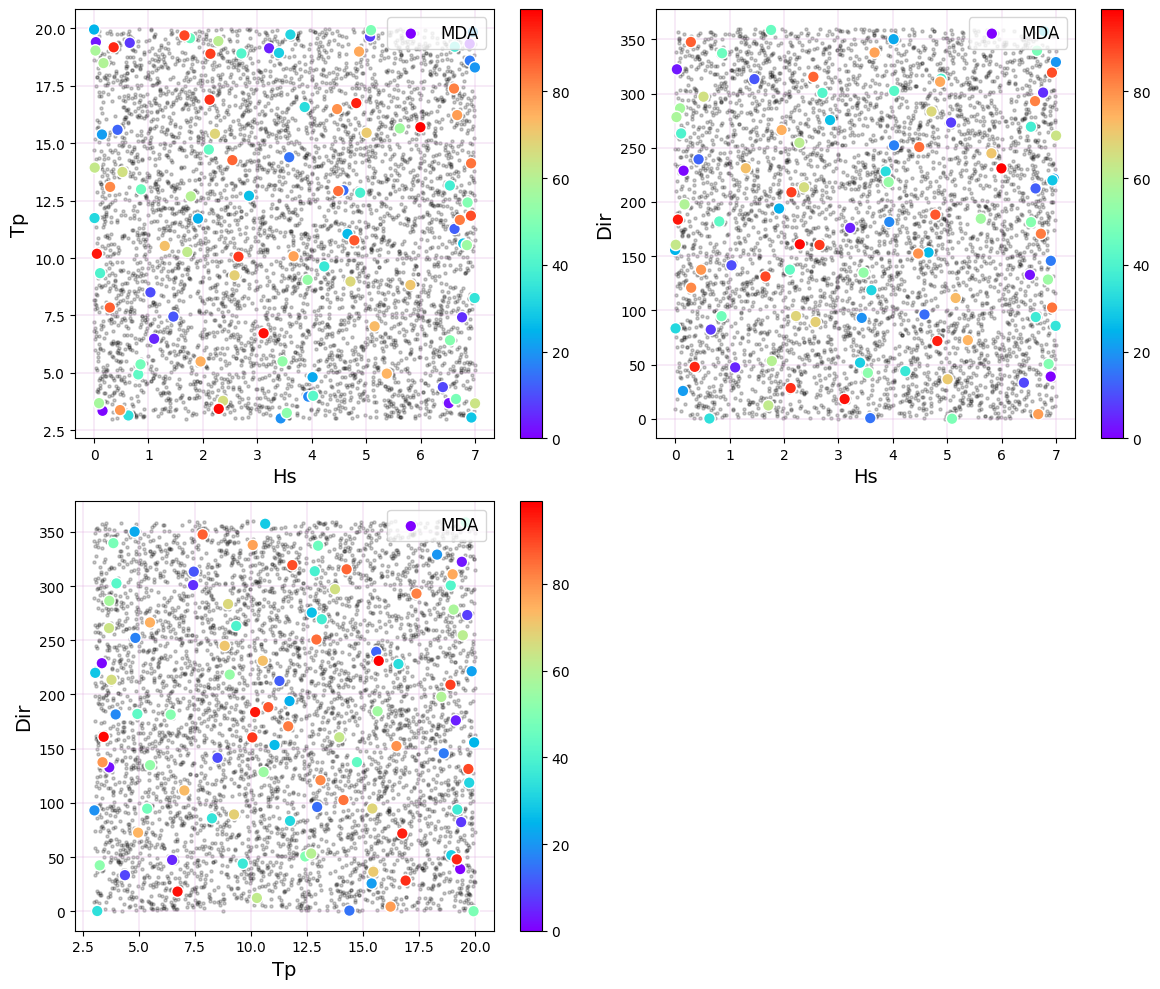

In [4]:

vars = ['Hs', 'Tp', 'Dir']  # Lista de variables
sel_mda = mda.centroids[vars]  # Selección de puntos
plot_variable_combinations(mda.data, vars, mda.centroids, labels = 'MDA')


# MDA + RBF

The energy flux EF, depends on the variables Hs and Tp, and can be computed follwing: EF = Hs**2 * Tp

In [5]:
target = pd.DataFrame(
    {
        "EF": mda.centroids.Hs.values**2 * mda.centroids.Tp.values,
    }
)

/lustre/geocean/WORK/users/Laura/BlueMath/toolkit/datamining/utils/plotting.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(v1, v2, c=data_color, s=size_point, cmap  = 'rainbow', alpha=0.2)


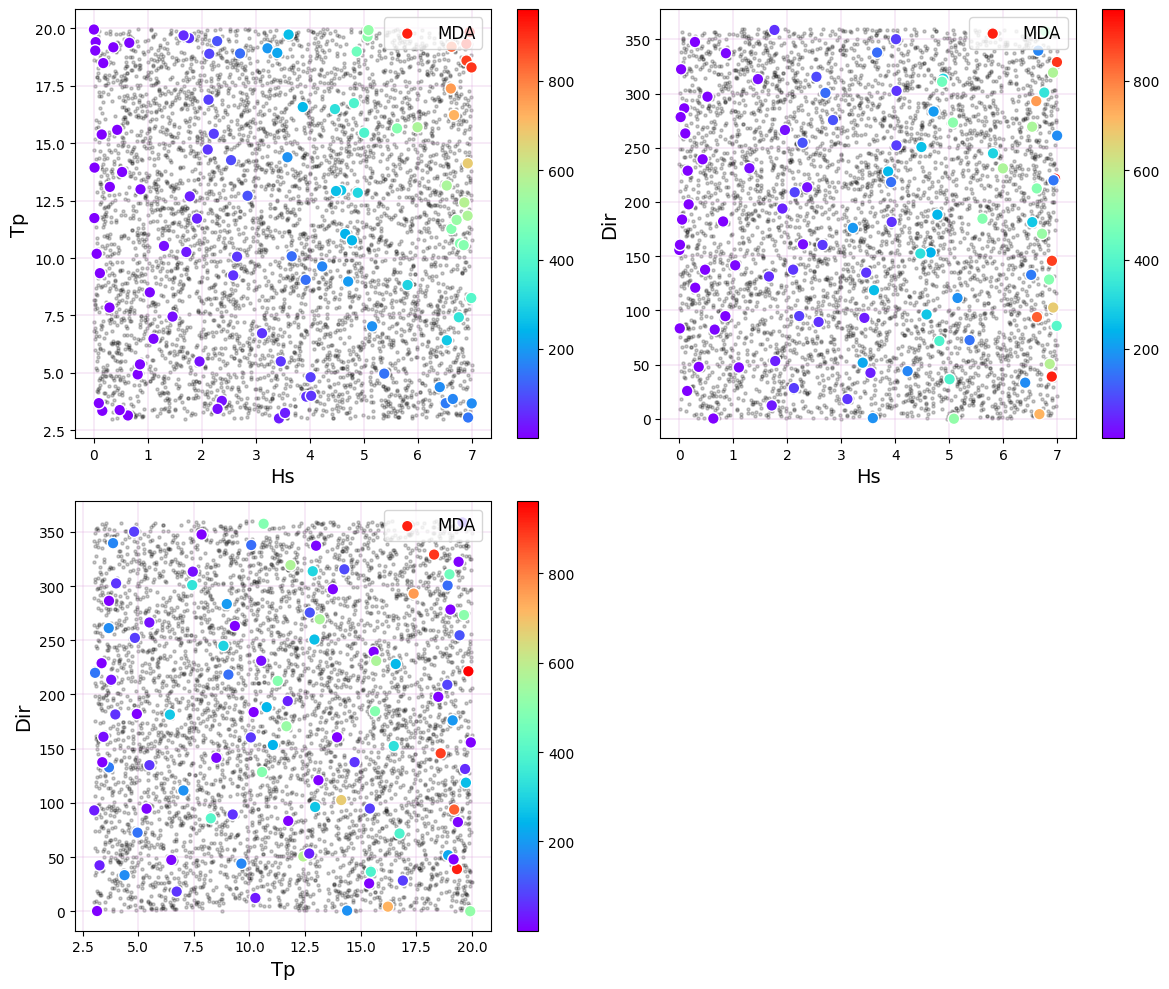

In [6]:

vars = ['Hs', 'Tp', 'Dir']  # Lista de variables
sel_mda = mda.centroids[vars]  # Selección de puntos
plot_variable_combinations(mda.data, vars, mda.centroids, sel_color = target.EF, labels = 'MDA')


## RBF

In [7]:
dataset = data # Data to interpolate
 
subset = mda.centroids # Parameters to fit RBF
target = target # Response to fit RBF


subset_directional_variables = ['Dir']
target_directional_variables = []

In [8]:
rbf = RBF()

predictions = rbf.fit_predict(
    subset_data=subset,
    subset_directional_variables=subset_directional_variables,
    target_data=target,
    target_directional_variables=target_directional_variables,
    normalize_target_data=True,
    dataset=dataset,
    num_workers=4,
    iteratively_update_sigma=True,
)
print(predictions.head())

2025-03-31 18:57:47,555 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 18:57:48,247 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 18:57:48,250 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 18:57:48,251 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 18:57:48,252 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 18:57:48,252 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 18:57:48,254 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 18:57:48,255 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint


           EF
0  672.895281
1   23.828712
2    5.911817
3    3.204461
4    9.140210


In [9]:
predictions

,EF
0,672.895281
1,23.828712
2,5.911817
3,3.204461
4,9.140210
...,...
4995,149.233878
4996,147.684530
4997,66.103205
4998,211.593142


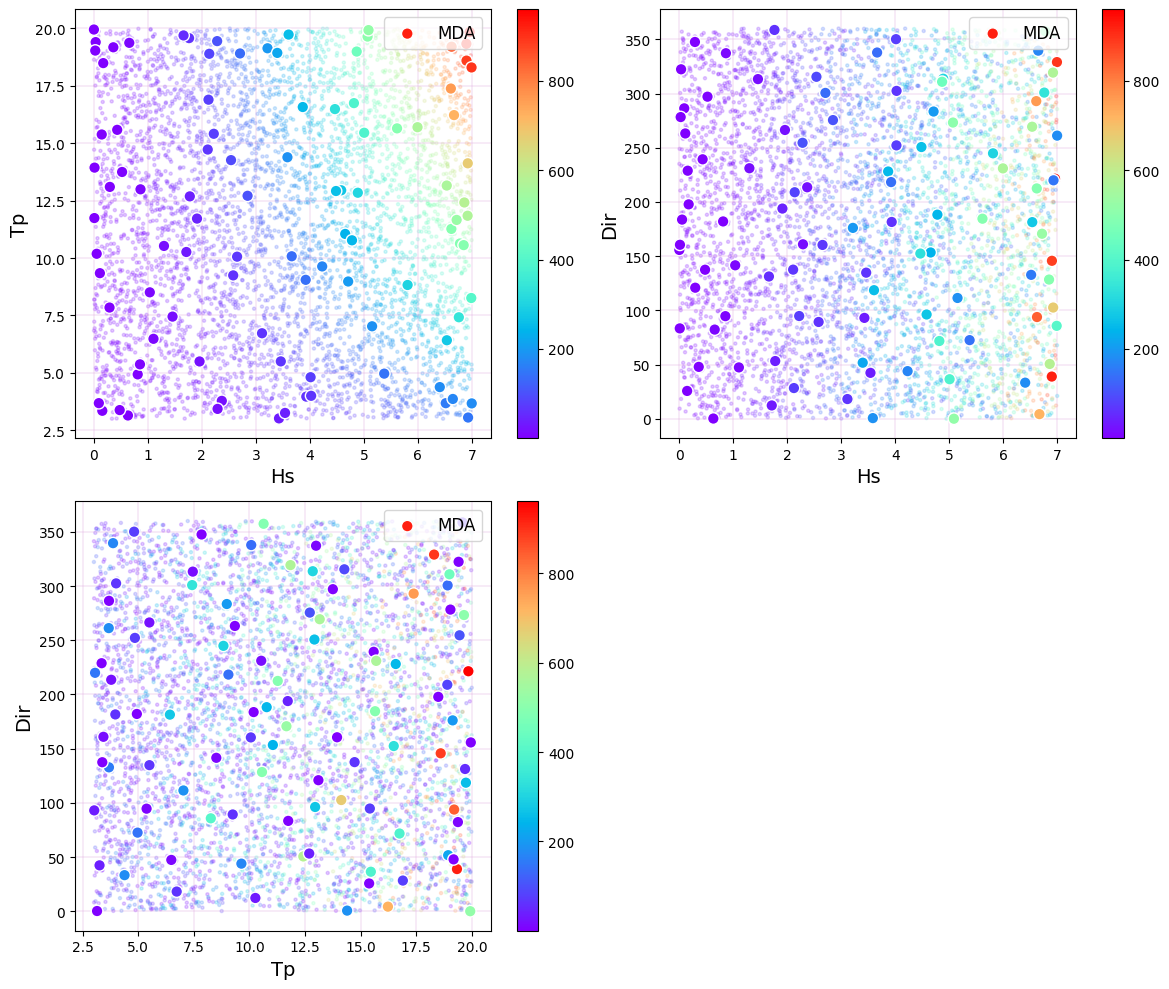

In [10]:

vars = ['Hs', 'Tp', 'Dir']  # Lista de variables
sel_mda = mda.centroids[vars]  # Selección de puntos
plot_variable_combinations(mda.data, vars, mda.centroids, data_color = predictions.EF, sel_color = target.EF, labels = 'MDA')


## 14. Root Mean Square Error

$$\textbf{RMSE =  } sqrt(\frac{\sum(RBF_{model} - Real)^2}{n})$$


In [14]:
RMSE = np.sqrt(np.mean((predictions.EF - (data.Hs**2*data.Tp))**2))

## 15. Optimal number of points

- Seleccionar 50 valores entre 50 y 500

In [23]:
num_centers_explore = np.arange(10, 600, 50)

In [24]:
RMSE = []

for d in num_centers_explore:
    
    #MDA
    dir_vars = ['Dir']

    mda = MDA(num_centers=d)
    nearest_centroids_idxs, nearest_centroids_df = mda.fit_predict(
        data=data,
        directional_variables=dir_vars,
    )

    target = pd.DataFrame(
    {
        "EF": mda.centroids.Hs.values**2 * mda.centroids.Tp.values,
    }
    )


    # RBF

    subset = mda.centroids # Parameters to fit RBF
    target = target # Response to fit RBF

    rbf = RBF()

    predictions = rbf.fit_predict(
        subset_data=subset,
        subset_directional_variables=subset_directional_variables,
        target_data=target,
        target_directional_variables=target_directional_variables,
        normalize_target_data=True,
        dataset=dataset,
        num_workers=4,
        iteratively_update_sigma=True,
    )

    RMSE.append(np.sqrt(np.mean((predictions.EF - (data.Hs**2*data.Tp))**2)))
    

2025-03-31 19:05:45,934 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:05:46,212 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:05:46,221 - RBF - WARNING - Proposed min custom scaler for Hs is bigger than datapoint
2025-03-31 19:05:46,222 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:05:46,223 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:05:46,223 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:05:46,224 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:05:46,224 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:05:46,225 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:05:46,225 - RBF -


        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:05:46,616 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:05:46,967 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:05:46,968 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:05:46,969 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:05:46,970 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:05:46,970 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:05:46,971 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:05:46,972 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint
2025-03-31 19:05:47,023 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:05:47,440 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:05:48,429 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:05:48,430 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:05:48,432 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:05:48,433 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:05:48,434 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:05:48,436 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:05:48,437 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint
2025-03-31 19:05:48,533 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:05:48,984 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:05:52,431 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:05:52,433 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:05:52,433 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:05:52,434 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:05:52,435 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:05:52,436 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:05:52,436 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint
2025-03-31 19:05:52,515 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:05:52,998 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:05:57,199 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:05:57,201 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:05:57,203 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:05:57,204 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:05:57,205 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:05:57,207 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:05:57,208 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint
2025-03-31 19:05:57,359 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:05:57,871 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:06:03,094 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:06:03,095 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:06:03,096 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:06:03,097 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:06:03,097 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:06:03,098 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:06:03,099 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint
2025-03-31 19:06:03,205 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:06:03,702 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:06:10,526 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:06:10,527 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:06:10,528 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:06:10,529 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:06:10,530 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:06:10,530 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:06:10,531 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint
2025-03-31 19:06:10,659 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:06:11,193 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:06:21,144 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:06:21,146 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:06:21,147 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:06:21,148 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:06:21,148 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:06:21,149 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:06:21,150 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint
2025-03-31 19:06:21,370 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:06:21,916 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:06:30,433 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:06:30,435 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:06:30,435 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:06:30,436 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:06:30,437 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:06:30,438 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:06:30,438 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint
2025-03-31 19:06:30,682 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:06:31,268 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:06:42,210 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:06:42,211 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:06:42,212 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:06:42,213 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:06:42,213 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:06:42,214 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:06:42,215 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint
2025-03-31 19:06:42,458 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:06:43,122 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:06:56,629 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:06:56,631 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:06:56,631 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:06:56,632 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:06:56,632 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:06:56,633 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:06:56,634 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint
2025-03-31 19:06:56,906 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 19:06:57,590 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-03-31 19:07:16,624 - RBF - WARNING - Proposed max custom scaler for Hs is lower than datapoint
2025-03-31 19:07:16,626 - RBF - WARNING - Proposed min custom scaler for Tp is bigger than datapoint
2025-03-31 19:07:16,627 - RBF - WARNING - Proposed max custom scaler for Tp is lower than datapoint
2025-03-31 19:07:16,628 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-03-31 19:07:16,628 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-03-31 19:07:16,629 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-03-31 19:07:16,630 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint


Text(0, 0.5, 'RMSE')

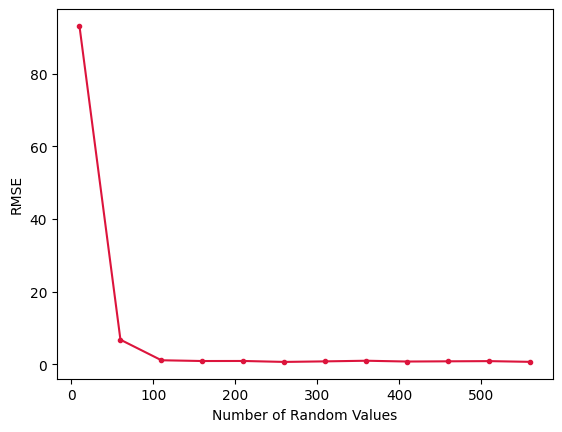

In [25]:
plt.plot(num_centers_explore, RMSE, '.-' ,color = 'crimson')
plt.xlabel('Number of Random Values')
plt.ylabel('RMSE')